In [ ]:
#!pip install scipy==1.12.0
#!pip install rouge_score

In [1]:
import tokenize
import os
import string
import re 
import sys
import pdfquery
#from pypdf import PdfReader 
from pdfquery import PDFQuery
import flask
import requests
#import pandas as pd
import nltk
#nltk.download()
from nltk.translate.bleu_score import modified_precision
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize
import warnings
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity
# import spacy 
import requests 
from fractions import Fraction
# from spacy import displacy
# from bs4 import BeautifulSoup
# import torch # type: ignore
from transformers import AutoModelForQuestionAnswering, AutoTokenizer, pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5Config, T5ForConditionalGeneration, T5Tokenizer
# pip install tensorflow
# pip install tf-keras
# pip install textblob
# pip install allennlp
# pip install scipy=1.12.0
# pip install torch
from textblob import TextBlob
# import allennlp
# from allennlp.predictors import Predictor
# from bert_score import score
# from evaluate import load
# bertscore = load("bertscore")
# Pratical 11
from rouge_score import rouge_scorer
import gensim
from accessory_functions import google_vec_file


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tqz11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tqz11\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\tqz11\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tqz11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\tqz11\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
def remove_text_after_word(text, word):
    index = text.find(word)
    if index != -1:
        return text[:index]
    else:
        return text

def textpreprocessing(text):

    text_to_remove = "Evaluation Warning: The document was created with Spire.Doc for Python."
    cleaned_text = text.replace(text_to_remove, '')

    word_to_remove_after = "REFERENCES"
    cleaned_text = remove_text_after_word(cleaned_text, word_to_remove_after)
    
    # Regular expression pattern to match citations (Format for citation = [1])
    citation_pattern = r'\[[0-9]+\]'
    # Replace citations with an empty string
    cleaned_text = re.sub(citation_pattern, '', cleaned_text)

    # Regular expression pattern to match APA style citations (Format for citation = (Name, year))
    apa_citation_pattern = r'\(\w+,\s*\d{4}\)'
    # Replace APA style citations with an empty string
    cleaned_text = re.sub(apa_citation_pattern, '', cleaned_text)

    # Cleaning Text (Remove Email / Remove URL)
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Replace URLs with an empty string
    cleaned_text = re.sub(url_pattern, '', cleaned_text)

    # Cleaning Text (Remove Email / Remove URL)
    # Regular expression pattern to match email addresses
    email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
    # Replace email addresses with an empty string
    cleaned_text = re.sub(email_pattern, '', cleaned_text)

    # Replace the ? and ! to .
    cleaned_text = cleaned_text.replace('!', '.')
    cleaned_text = cleaned_text.replace('?', '.')

    # Regular expression pattern to match punctuation marks except period
    punctuation_pattern = r'[^\w\s\.\s]'
    # Replace punctuation marks except period with an empty string
    cleaned_text = re.sub(punctuation_pattern, '', cleaned_text)

    # Lowercasing
    cleaned_text = cleaned_text.lower()

    # Tokenize the text into words
    tokenize_text = word_tokenize(cleaned_text)

    # NLTK STOP WORD
    # text_stopwords = [word for word in tokenize_text if not word in stopwords.words()]

    lemmatizer=WordNetLemmatizer()
    lemmatized_content = []

    for word in tokenize_text:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_content.append(lemmatized_word)
    
    # Joining the lemmatized words back into a string
    cleaned_text = ' '.join(lemmatized_content)
    return cleaned_text 

def tokenize_and_lemmatize(text):
    # Tokenize the text into words
    tokens = word_tokenize(text)
    
    # Initialize WordNet lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Lemmatize each token
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return lemmatized_tokens

In [3]:
pdf = pdfquery.PDFQuery("reading_part2_2021.pdf")
pdf.load()
text = pdf.pq('LTTextLineHorizontal').text()
text = textpreprocessing(text)
print(text)

to from subject apology for not attending lecture dear dr rashidah thank you for your email regarding my absence from class . my friend told me that you had written to me a few day ago . unfortunately there is something wrong with my student email and i have not been able to use it since january 2021. i am now writing to you using my personal email . i would like to explain my absence from your lecture for the past two week and for having not informed you earlier . i wa unwell on 17 february 2021. however i did not consult a doctor because i wa too weak and took a painkiller instead . a a result i did not have a medical certificate to hand in . on 24 february 2021 i could not come to class because i had to attend my sister wedding in my village . in fact i had asked my friend who wa in the same class to inform you but she forgot and went to the library to meet friend . for your information i had planned to come back to the university immediately after my sister wedding . but there wa h

In [16]:
# =============================== Q&A ==================================================
# ============== START TAI QI ZHENG
def deepset_tinyroberta_squad2(input, text):

    errorReplay = "I don't know what 7 you say"

    model_name = "deepset/tinyroberta-squad2"
    nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)

    input = textpreprocessing(input)

    res = nlp(input, text)
    print(input)
    print(res)

    #prediction = textpreprocessing(res['answer'])
    #prediction = tokenize_and_lemmatize(prediction)
    #Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']

def deepset_roberta_base_squad2(input, text):
    model_name = "deepset/roberta-base-squad2"
    nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
    res = nlp(input, text)
    print(input)
    print(res)
    #prediction = textpreprocessing(res['answer'])
    #prediction = tokenize_and_lemmatize(prediction)
#     Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']
# ============== END   TAI QI ZHENG

# ============== START TAN XUE WEN

# BERT
def QandA_BERT(input, text):
    model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
    nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
    input = textpreprocessing(input)
    res = nlp(question=input, context=text)
    print(input)
    print(res)

#     prediction = textpreprocessing(res['answer'])
#     prediction = tokenize_and_lemmatize(prediction)
    #Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']

# DISTILBERT
def QandA_DistilBERT(input, text):
    model_name = "distilbert-base-uncased-distilled-squad"
    nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
    input = textpreprocessing(input)
    res = nlp(question=input, context=text)
    print(input)
    print(res)

#     prediction = textpreprocessing(res['answer'])
#     prediction = tokenize_and_lemmatize(prediction)
    #Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']

# ============== END   TAN XUE WEN

# ============== START KONG KAI LE
def deepset_electra_base_squad2(input, text):
    model_name = "deepset/electra-base-squad2"
    nlp = pipeline('question-answering', model=model_name, tokenizer=model_name)
    input = textpreprocessing(input)
    res = nlp(question=input, context=text)
    print(input)
    print(res)

#     prediction = textpreprocessing(res['answer'])
#     prediction = tokenize_and_lemmatize(prediction)
    #Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']

def etalab_ia(input, text):
    model_name = "etalab-ia/camembert-base-squadFR-fquad-piaf"
    nlp = pipeline('question-answering', model='etalab-ia/camembert-base-squadFR-fquad-piaf', tokenizer='etalab-ia/camembert-base-squadFR-fquad-piaf')
    input = textpreprocessing(input)
    res = nlp(question=input, context=text)
    print(input)
    print(res)

#     prediction = textpreprocessing(res['answer'])
#     prediction = tokenize_and_lemmatize(prediction)
    #Evaluation_QandA(prediction)
#     print(prediction)
    return res['answer']
# ============== END   KONG KAI LE
# =============================== Q&A ==================================================

In [17]:
# Performance Measurement for Q&A
references0 = "he wanted to say sorry for missing her classes"
references1 = "he went home to attend his sister wedding in his village"
references2 = "of the bad weather"
references3 = "to take the listening test"
references4 = "to come early for all Dr Rashidahs class"

references5 = "Review of Brain Tumour Segmentation, Detection and Classification Algorithms in fMRI Images"
references6 = "malignant tumor and benign tumor"
references7 = "functional magnetic resonance imaging fmri or magnetic resonance imaging mri"
references8 = "headaches, nausea and problems concerning balance, hearing and vision."
references9 = "researchers all over the world"

#Q01 what is the reason he writing this email
#Q02 why he missed the second class
#Q03 why he missed the flight
#Q04 what he request in email
#Q05 what he promising

#Q06 title for this paper
#Q07 What is the main type of brain tumour
#Q08 How the doctors detect and classify tumours
#Q09 Symptoms for brain tumors
#Q10 This paper is to motivate who


def Evaluation_QandA(predictions):
    global references0, references1, references2, references3, references4, references5, references6, references7, references8, references9
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    AIans = " ".join(predictions)

    scores0 = scorer.score(AIans, references0)
    scores1 = scorer.score(AIans, references1)
    scores2 = scorer.score(AIans, references2)
    scores3 = scorer.score(AIans, references3)
    scores4 = scorer.score(AIans, references4)
    scores5 = scorer.score(AIans, references5)
    scores6 = scorer.score(AIans, references6)
    scores7 = scorer.score(AIans, references7)
    scores8 = scorer.score(AIans, references8)
    scores9 = scorer.score(AIans, references9)


    print("======================================")
    print("Question 1")
    print(scores0)
    print("======================================")
    print("Question 2")
    print(scores1)
    print("======================================")
    print("Question 3")
    print(scores2)
    print("======================================")
    print("Question 4")
    print(scores3)
    print("======================================")
#     print("Question 5")
#     print(scores4)
#     print("======================================")
#     print("Question 6")
#     print(scores5)
#     print("======================================")
#     print("Question 7")
#     print(scores6)
#     print("======================================")
#     print("Question 8")
#     print(scores7)
#     print("======================================")
#     print("Question 9")
#     print(scores8)
#     print("======================================")
#     print("Question 10")
#     print(scores9)
#     print("======================================")

In [21]:
userinput = ""
userinput = input("Enter question:")
print("Question: " + userinput)

ans1 = deepset_tinyroberta_squad2(userinput, text)
ans1 = textpreprocessing(ans1)
ans1 = tokenize_and_lemmatize(ans1)

ans2 = deepset_roberta_base_squad2(userinput, text)
ans2 = textpreprocessing(ans2)
ans2 = tokenize_and_lemmatize(ans2)

ans3 = QandA_BERT(userinput, text)
ans3 = textpreprocessing(ans3)
ans3 = tokenize_and_lemmatize(ans3)

ans4 = QandA_DistilBERT(userinput, text)
ans4 = textpreprocessing(ans4)
ans4 = tokenize_and_lemmatize(ans4)

ans5 = deepset_electra_base_squad2(userinput, text)
ans5 = textpreprocessing(ans5)
ans5 = tokenize_and_lemmatize(ans5)

# ans6 = etalab_ia(userinput, text)
# ans6 = textpreprocessing(ans6)
# ans6 = tokenize_and_lemmatize(ans6)

references1 = "he went home to attend his sister wedding in his village"
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

AIans1 = " ".join(ans1)
AIans2 = " ".join(ans2)
AIans3 = " ".join(ans3)
AIans4 = " ".join(ans4)
AIans5 = " ".join(ans5)
# AIans6 = " ".join(ans6)

print(AIans1)
scores1 = scorer.score(AIans1, references1)
print(scores1)

print(AIans2)
scores2 = scorer.score(AIans2, references1)
print(scores2)

print(AIans3)
scores3 = scorer.score(AIans3, references1)
print(scores3)

print(AIans4)
scores4 = scorer.score(AIans4, references1)
print(scores4)

print(AIans5)
scores5 = scorer.score(AIans5, references1)
print(scores5)

# print(ans6)
# scores6 = scorer.score(AIans6, references1)
# print(scores6)

Enter question:why he missed the flight
Question: why he missed the flight
why he missed the flight
{'score': 0.012399470433592796, 'start': 990, 'end': 1047, 'answer': 'there wa heavy rain and my journey took longer than usual'}
why he missed the flight
{'score': 0.020790643990039825, 'start': 999, 'end': 1009, 'answer': 'heavy rain'}
why he missed the flight
{'score': 0.13315895199775696, 'start': 999, 'end': 1009, 'answer': 'heavy rain'}
why he missed the flight
{'score': 0.3005487322807312, 'start': 1284, 'end': 1345, 'answer': 'i might fail the course if i do not get any mark for the test'}
why he missed the flight
{'score': 2.074693554732221e-07, 'start': 436, 'end': 467, 'answer': 'having not informed you earlier'}
there wa heavy rain and my journey took longer than usual
{'rouge1': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rouge2': Score(precision=0.0, recall=0.0, fmeasure=0.0), 'rougeL': Score(precision=0.0, recall=0.0, fmeasure=0.0)}
heavy rain
{'rouge1': Score(precisi

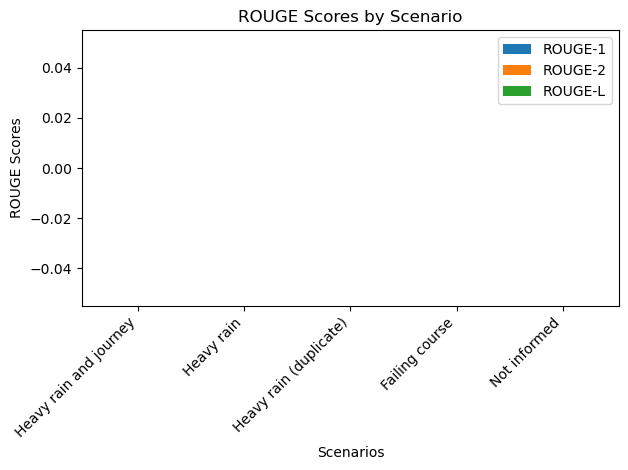

In [22]:
import matplotlib.pyplot as plt

# Data
data = {
    'Heavy rain and journey': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0},
    'Heavy rain': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0},
    'Heavy rain (duplicate)': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0},
    'Failing course': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0},
    'Not informed': {'rouge1': 0.0, 'rouge2': 0.0, 'rougeL': 0.0},
}

# Prepare data for plotting
labels = list(data.keys())
rouge1_scores = [data[label]['rouge1'] for label in labels]
rouge2_scores = [data[label]['rouge2'] for label in labels]
rougeL_scores = [data[label]['rougeL'] for label in labels]

x = range(len(labels))  # the label locations

# Width of the bars
width = 0.2  

fig, ax = plt.subplots()

# Plotting the bars
ax.bar(x, rouge1_scores, width, label='ROUGE-1')
ax.bar([p + width for p in x], rouge2_scores, width, label='ROUGE-2')
ax.bar([p + width*2 for p in x], rougeL_scores, width, label='ROUGE-L')

# Adding labels and title
ax.set_xlabel('Scenarios')
ax.set_ylabel('ROUGE Scores')
ax.set_title('ROUGE Scores by Scenario')
ax.set_xticks([p + width for p in x])
ax.set_xticklabels(labels, rotation=45, ha="right")

# Adding legend
ax.legend()

# Show plot
plt.tight_layout()
plt.show()